In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from data.bt_dataset import BrainTumorDataset
from model import BrainTumorCNN
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
import torch
import os
import cv2
from data.preprocessing import *
from train import train
from evaluate import evaluate
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    print("Working on: GPU")
    device = 'cuda'
else:
    print("Working on: CPU")
    device = 'cpu'

Working on: GPU


### Defining constants:

In [4]:
IMAGE_SIZE = 256
NUM_OF_CLASSES = 4
train_batch_size = test_batch_size = 64
dataset_path = os.path.join(os.getcwd(), 'data')

### Preprocessing:

In [5]:
# Resizing the images and sharpening them:
preprocessing_ops = [denoise(), normalize(), resize([IMAGE_SIZE, IMAGE_SIZE]), sharpen()]
preprocessing_ops = [resize([IMAGE_SIZE, IMAGE_SIZE]), sharpen()]
image_preprocessing = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.transforms.Normalize((0.16, 0.16, 0.16), (0.18,  0.18, 0.18)),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        lambda image : transforms.functional.adjust_sharpness(image, sharpness_factor=2)                                        ])


### Defining the dataset:

In [6]:
# Defining the Dataset object:
demo_dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=None)
dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=image_preprocessing)

In [7]:
dataset.get_data_distribution()

{'pituitary_tumor': 827,
 'glioma_tumor': 826,
 'meningioma_tumor': 822,
 'no_tumor': 395}

### Plotting a sample image

In [8]:
pre_processed_img = dataset[0][0]
original_image = demo_dataset[0][0]

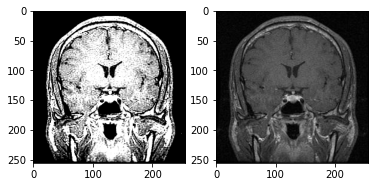

In [9]:
f, axarr = plt.subplots(1,2)

axarr[0].imshow(pre_processed_img.permute(1, 2, 0))
axarr[1].imshow(original_image.permute(0, 1, 2))

### Model specifications:

In [133]:
model = BrainTumorCNN(number_of_classes=NUM_OF_CLASSES, image_size=IMAGE_SIZE)

parameters = model.parameters()
learning_rate = 1e-4
weight_decay = 1e-1
momentum = 0.9

# Getting the class weights to apply weighted loss:
class_weights = torch.tensor(dataset.class_weights).float().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

In [134]:
scheduler = StepLR(optimizer, step_size=4, gamma=1.5)

In [135]:
sample_size = 10
overfitting_set = []
class_indicies_distrib = dataset.class_indicies_distribution()
for i in class_indicies_distrib:
    overfitting_set += class_indicies_distrib[i][:10]

## Overfitting the model in order to test if it can learn

In [136]:
overfitting_subset = Subset(dataset, overfitting_set)
overfitting_loader = DataLoader(overfitting_subset)

In [137]:
epochs = 17

In [117]:
# scheduler = None
total_loss, epoch_times, accuracies_train, _ = train(model=model, train_loader=overfitting_loader,
                                                                   test_loader=overfitting_loader, optimizer=optimizer,
                                                                   criterion=criterion, epochs=epochs, scheduler=scheduler)

100%|██████████| 40/40 [00:01<00:00, 26.65it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 0 | Loss: 544.38
Epoch: 0 took: 2.29 seconds


100%|██████████| 40/40 [00:00<00:00, 94.30it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 1 | Loss: 213.11
Epoch: 1 took: 1.05 seconds


100%|██████████| 40/40 [00:00<00:00, 87.75it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 2 | Loss: 89.71
Epoch: 2 took: 1.19 seconds


100%|██████████| 40/40 [00:00<00:00, 88.42it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 3 | Loss: 73.58
Epoch: 3 took: 1.25 seconds


100%|██████████| 40/40 [00:00<00:00, 90.78it/s]


Evaluating epoch...
Learning rate: 0.00015000000000000001
Epoch: 4 | Loss: 73.94
Epoch: 4 took: 1.09 seconds


100%|██████████| 40/40 [00:00<00:00, 79.62it/s] 


Evaluating epoch...
Learning rate: 0.00015000000000000001
Epoch: 5 | Loss: 65.58
Epoch: 5 took: 1.25 seconds


100%|██████████| 40/40 [00:00<00:00, 85.37it/s]


Evaluating epoch...
Learning rate: 0.00015000000000000001
Epoch: 6 | Loss: 56.75
Epoch: 6 took: 1.11 seconds


100%|██████████| 40/40 [00:00<00:00, 100.76it/s]


Evaluating epoch...
Learning rate: 0.00015000000000000001
Epoch: 7 | Loss: 52.09
Epoch: 7 took: 1.03 seconds


100%|██████████| 40/40 [00:00<00:00, 103.28it/s]


Evaluating epoch...
Learning rate: 0.00022500000000000002
Epoch: 8 | Loss: 52.42
Epoch: 8 took: 1.02 seconds


100%|██████████| 40/40 [00:00<00:00, 102.52it/s]


Evaluating epoch...
Learning rate: 0.00022500000000000002
Epoch: 9 | Loss: 47.79
Epoch: 9 took: 1.03 seconds


100%|██████████| 40/40 [00:00<00:00, 104.80it/s]


Evaluating epoch...
Learning rate: 0.00022500000000000002
Epoch: 10 | Loss: 42.48
Epoch: 10 took: 1.01 seconds


100%|██████████| 40/40 [00:00<00:00, 80.07it/s]


Evaluating epoch...
Learning rate: 0.00022500000000000002
Epoch: 11 | Loss: 38.73
Epoch: 11 took: 1.12 seconds


100%|██████████| 40/40 [00:00<00:00, 91.35it/s]


Evaluating epoch...
Learning rate: 0.0003375
Epoch: 12 | Loss: 38.68
Epoch: 12 took: 1.06 seconds


100%|██████████| 40/40 [00:00<00:00, 101.42it/s]


Evaluating epoch...
Learning rate: 0.0003375
Epoch: 13 | Loss: 34.88
Epoch: 13 took: 1.54 seconds


100%|██████████| 40/40 [00:00<00:00, 99.71it/s] 


Evaluating epoch...
Learning rate: 0.0003375
Epoch: 14 | Loss: 29.43
Epoch: 14 took: 1.07 seconds


100%|██████████| 40/40 [00:00<00:00, 93.92it/s] 


Evaluating epoch...
Learning rate: 0.0003375
Epoch: 15 | Loss: 25.58
Epoch: 15 took: 1.05 seconds


100%|██████████| 40/40 [00:00<00:00, 105.48it/s]


Evaluating epoch...
Learning rate: 0.00050625
Epoch: 16 | Loss: 24.82
Epoch: 16 took: 1.00 seconds


### Plotting the loss:

In [118]:
import matplotlib.pyplot as plt

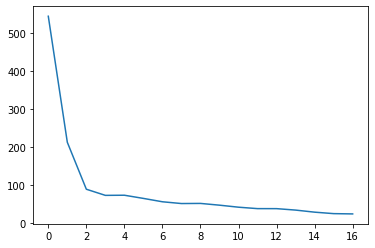

In [119]:
plt.plot(total_loss)
plt.show()

### Plotting train accuracy:

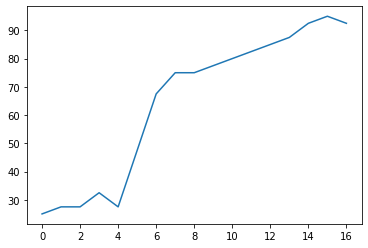

In [120]:
plt.plot(accuracies_train)
plt.show()

In [121]:
accuracy = evaluate(model=model, test_loader=overfitting_loader)
print(f'Overfitting Accuracy: {accuracy:.2f}%')

Overfitting Accuracy: 92.50%


### Creating the model to train it

In [138]:
model = BrainTumorCNN(number_of_classes=NUM_OF_CLASSES, image_size=IMAGE_SIZE)

parameters = model.parameters()
learning_rate = 1e-4
weight_decay = 1e-1
momentum = 0.9

# Getting the class weights to apply weighted loss:
class_weights = torch.tensor(dataset.class_weights).float().to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

### Training the model

In [139]:
# Defining the Dataset object:
test_dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=image_preprocessing, test=True)
train_dataset = BrainTumorDataset(dataset_path=dataset_path, preprocessing=image_preprocessing, test=False)

# Defining the DataLoader object:
test_loader = DataLoader(test_dataset, batch_size=train_batch_size)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size)

In [140]:
scheduler = StepLR(optimizer, step_size=10, gamma=1.2)

In [141]:
epochs = 40

In [142]:
# scheduler = None
total_loss, epoch_times, accuracies_train, accuracies_test = train(model=model, train_loader=train_loader,
                                                                   test_loader=test_loader, optimizer=optimizer,
                                                                   criterion=criterion, epochs=epochs, scheduler=scheduler)

100%|██████████| 45/45 [00:23<00:00,  1.90it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 0 | Loss: 476.94
Epoch: 0 took: 49.50 seconds


100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 1 | Loss: 202.19
Epoch: 1 took: 48.48 seconds


100%|██████████| 45/45 [00:24<00:00,  1.85it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 2 | Loss: 88.84
Epoch: 2 took: 49.70 seconds


100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 3 | Loss: 77.47
Epoch: 3 took: 48.02 seconds


100%|██████████| 45/45 [00:22<00:00,  2.02it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 4 | Loss: 72.78
Epoch: 4 took: 51.85 seconds


100%|██████████| 45/45 [00:22<00:00,  1.99it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 5 | Loss: 69.83
Epoch: 5 took: 47.52 seconds


100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 6 | Loss: 67.68
Epoch: 6 took: 48.21 seconds


100%|██████████| 45/45 [00:22<00:00,  2.00it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 7 | Loss: 66.05
Epoch: 7 took: 47.51 seconds


100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 8 | Loss: 64.77
Epoch: 8 took: 47.62 seconds


100%|██████████| 45/45 [00:22<00:00,  2.01it/s]


Evaluating epoch...
Learning rate: 0.0001
Epoch: 9 | Loss: 63.74
Epoch: 9 took: 47.76 seconds


100%|██████████| 45/45 [00:22<00:00,  2.03it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 10 | Loss: 64.20
Epoch: 10 took: 47.17 seconds


100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 11 | Loss: 63.20
Epoch: 11 took: 48.39 seconds


100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 12 | Loss: 62.37
Epoch: 12 took: 48.72 seconds


100%|██████████| 45/45 [00:23<00:00,  1.90it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 13 | Loss: 61.66
Epoch: 13 took: 49.12 seconds


100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 14 | Loss: 61.08
Epoch: 14 took: 47.99 seconds


100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 15 | Loss: 60.58
Epoch: 15 took: 48.00 seconds


100%|██████████| 45/45 [00:23<00:00,  1.93it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 16 | Loss: 60.17
Epoch: 16 took: 49.68 seconds


100%|██████████| 45/45 [00:25<00:00,  1.75it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 17 | Loss: 59.81
Epoch: 17 took: 52.26 seconds


100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 18 | Loss: 59.50
Epoch: 18 took: 48.82 seconds


100%|██████████| 45/45 [00:22<00:00,  1.99it/s]


Evaluating epoch...
Learning rate: 0.00012
Epoch: 19 | Loss: 59.23
Epoch: 19 took: 48.48 seconds


100%|██████████| 45/45 [00:22<00:00,  2.01it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 20 | Loss: 59.74
Epoch: 20 took: 47.63 seconds


100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 21 | Loss: 59.45
Epoch: 21 took: 51.43 seconds


100%|██████████| 45/45 [00:22<00:00,  1.96it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 22 | Loss: 59.20
Epoch: 22 took: 48.47 seconds


100%|██████████| 45/45 [00:22<00:00,  1.99it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 23 | Loss: 58.97
Epoch: 23 took: 48.70 seconds


100%|██████████| 45/45 [00:22<00:00,  2.01it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 24 | Loss: 58.77
Epoch: 24 took: 47.81 seconds


100%|██████████| 45/45 [00:23<00:00,  1.92it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 25 | Loss: 58.58
Epoch: 25 took: 48.58 seconds


100%|██████████| 45/45 [00:23<00:00,  1.96it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 26 | Loss: 58.42
Epoch: 26 took: 49.03 seconds


100%|██████████| 45/45 [00:23<00:00,  1.94it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 27 | Loss: 58.28
Epoch: 27 took: 48.96 seconds


100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 28 | Loss: 58.15
Epoch: 28 took: 50.22 seconds


100%|██████████| 45/45 [00:23<00:00,  1.91it/s]


Evaluating epoch...
Learning rate: 0.000144
Epoch: 29 | Loss: 58.04
Epoch: 29 took: 48.86 seconds


100%|██████████| 45/45 [00:25<00:00,  1.76it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 30 | Loss: 58.49
Epoch: 30 took: 51.04 seconds


100%|██████████| 45/45 [00:21<00:00,  2.05it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 31 | Loss: 58.36
Epoch: 31 took: 47.20 seconds


100%|██████████| 45/45 [00:23<00:00,  1.94it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 32 | Loss: 58.25
Epoch: 32 took: 50.90 seconds


100%|██████████| 45/45 [00:22<00:00,  2.04it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 33 | Loss: 58.14
Epoch: 33 took: 46.78 seconds


100%|██████████| 45/45 [00:22<00:00,  1.99it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 34 | Loss: 58.03
Epoch: 34 took: 47.59 seconds


100%|██████████| 45/45 [00:22<00:00,  2.00it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 35 | Loss: 57.94
Epoch: 35 took: 47.15 seconds


100%|██████████| 45/45 [00:22<00:00,  1.97it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 36 | Loss: 57.85
Epoch: 36 took: 48.34 seconds


100%|██████████| 45/45 [00:21<00:00,  2.05it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 37 | Loss: 57.77
Epoch: 37 took: 46.99 seconds


100%|██████████| 45/45 [00:22<00:00,  1.98it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 38 | Loss: 57.70
Epoch: 38 took: 47.73 seconds


100%|██████████| 45/45 [00:22<00:00,  2.01it/s]


Evaluating epoch...
Learning rate: 0.0001728
Epoch: 39 | Loss: 57.63
Epoch: 39 took: 47.50 seconds


### Plotting the loss:

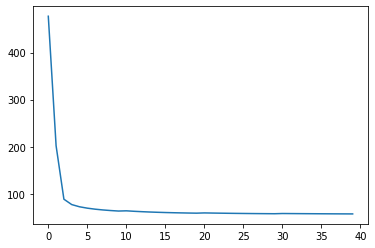

In [143]:
plt.plot(total_loss)
plt.show()

### Plotting train and test accuracies:

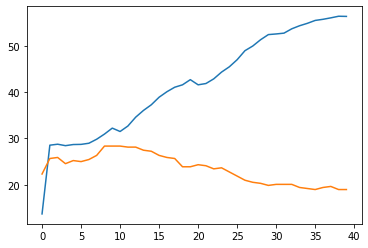

In [144]:
plt.plot(accuracies_train)
plt.plot(accuracies_test)
plt.show()

### Evaluating the model:

In [145]:
accuracy = evaluate(model=model, test_loader=test_loader)

In [146]:
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 18.97%


In [147]:
accuracy = evaluate(model=model, test_loader=train_loader)

In [148]:
print(f'Train Accuracy: {accuracy:.2f}%')

Train Accuracy: 56.32%
